In [1]:
0# get a folder full of images whre the image-classifiers are wrong
# prepare VIT models
# compute alignment scores
# get spearman correlation 
# plot the correlation matrix

0

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from datasets import load_dataset
from metrics import AlignmentMetrics  
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns
import timm
import torch
import torch.nn.functional as F

In [4]:
# -------------------- Initialization --------------------

import os
import torch
import torch.nn.functional as F
import timm
import numpy as np
from PIL import Image
from tqdm import tqdm

# List of models to pre-download weights for
model_list = [
    "vit_tiny_patch16_224.augreg_in21k",
    "vit_small_patch16_224.augreg_in21k",
    "vit_base_patch16_224.augreg_in21k",
    "vit_large_patch16_224.augreg_in21k",
    "vit_base_patch16_224.mae",
    "vit_large_patch16_224.mae",
    "vit_huge_patch14_224.mae",
    "vit_small_patch14_dinov2.lvd142m",
    "vit_base_patch14_dinov2.lvd142m",
    "vit_large_patch14_dinov2.lvd142m",
    "vit_giant_patch14_dinov2.lvd142m",
    "vit_base_patch16_clip_224.laion2b",
    "vit_large_patch14_clip_224.laion2b",
    "vit_huge_patch14_clip_224.laion2b",
    "vit_base_patch16_clip_224.laion2b_ft_in12k",
    "vit_large_patch14_clip_224.laion2b_ft_in12k",
    "vit_huge_patch14_clip_224.laion2b_ft_in12k",
]

# Directory to store saved features
FEATURES_DIR = "model_features_rnd"
os.makedirs(FEATURES_DIR, exist_ok=True)

# -------------------- Random Image Generation --------------------

def generate_random_images(num_images=1000, image_size=(224, 224), distribution="uniform"):
    """
    Generate random images with specified distribution.
    Supported distributions: 'uniform', 'normal'
    """
    images = []
    for _ in tqdm(range(num_images), desc="Generating random images"):
        if distribution == "uniform":
            array = np.random.randint(0, 256, size=(image_size[1], image_size[0], 3), dtype=np.uint8)
        elif distribution == "normal":
            array = np.random.normal(loc=127.5, scale=40, size=(image_size[1], image_size[0], 3))
            array = np.clip(array, 0, 255).astype(np.uint8)
        else:
            raise ValueError(f"Unsupported distribution: {distribution}")
        
        image = Image.fromarray(array, 'RGB')
        images.append(image)
    return images

# Generate 1000 random images with uniform distribution
sampled_images = generate_random_images(num_images=1000, image_size=(224, 224), distribution="uniform")

# -------------------- Feature Extraction Functions --------------------

def convert_to_rgb(image):
    """
    Convert a PIL image to RGB if it's not already.
    """
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image

def extract_features(model_name, images, batch_size=32):
    """
    Extract the CLS token from the last layer of the model for all images.
    """
    feature_path = os.path.join(FEATURES_DIR, f"{model_name}_features.pt")
    
    # Check if features are already extracted
    if os.path.exists(feature_path):
        print(f"Loading existing features for {model_name}...")
        features = torch.load(feature_path)
        return features
    
    print(f"Extracting features for {model_name}...")
    
    try:
        # Load the model
        model = timm.create_model(model_name, pretrained=True)
        model.eval()
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")
        return None
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define preprocessing transforms based on model's default config
    input_size = model.default_cfg.get('input_size', (3, 224, 224))
    transform = timm.data.transforms_factory.create_transform(
        input_size=input_size,
        is_training=False
    )
    
    features = []
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            try:
                # Apply transforms and stack into a batch tensor
                batch = torch.stack([transform(convert_to_rgb(img)) for img in batch_images]).to(device)
                
                # Forward pass to get features
                outputs = model.forward_features(batch)  # Shape: (batch_size, num_tokens, feature_dim)
                
                # Extract CLS token (first token)
                cls_tokens = outputs[:, 0, :]  # Shape: (batch_size, feature_dim)
                
                # Normalize features
                cls_tokens = F.normalize(cls_tokens, dim=-1)
                
                features.append(cls_tokens.cpu())
            except Exception as e:
                print(f"Error processing batch {i // batch_size} for {model_name}: {e}")
                continue
    
    if features:
        # Concatenate all features
        features = torch.cat(features, dim=0)  # Shape: (num_images, feature_dim)
        
        # Save features to disk
        torch.save(features, feature_path)
        print(f"Features for {model_name} saved to {feature_path}")
        return features
    else:
        print(f"No features extracted for {model_name}.")
        return None

def load_or_extract_features(model_name, images, batch_size=32):
    """
    Loads the precomputed features for a model if they exist.
    Otherwise, extracts the features and saves them.
    """
    feature_path = os.path.join(FEATURES_DIR, f"{model_name}_features.pt")
    if os.path.exists(feature_path):
        print(f"Loading features for {model_name} from {feature_path}...")
        features = torch.load(feature_path, map_location='cpu')
        print(f"Features for {model_name} loaded successfully, shape: {features.shape}")
        return features
    return extract_features(model_name, images, batch_size)

# -------------------- Feature Extraction Phase --------------------

# Extract features for all models
model_features = {}

for model_name in tqdm(model_list, desc="Extracting features for all models"):
    features = load_or_extract_features(model_name, sampled_images, batch_size=32)
    if features is not None:
        model_features[model_name] = features
    else:
        print(f"Features for {model_name} could not be extracted.")

Extracting features for all models:   0%|          | 0/17 [00:00<?, ?it/s]

Extracting features for vit_tiny_patch16_224.augreg_in21k...


Extracting features for all models:   6%|▌         | 1/17 [00:02<00:41,  2.56s/it]

Features for vit_tiny_patch16_224.augreg_in21k saved to model_features_rnd/vit_tiny_patch16_224.augreg_in21k_features.pt
Extracting features for vit_small_patch16_224.augreg_in21k...


Extracting features for all models:  12%|█▏        | 2/17 [00:04<00:34,  2.33s/it]

Features for vit_small_patch16_224.augreg_in21k saved to model_features_rnd/vit_small_patch16_224.augreg_in21k_features.pt
Extracting features for vit_base_patch16_224.augreg_in21k...


Extracting features for all models:  18%|█▊        | 3/17 [00:08<00:41,  2.99s/it]

Features for vit_base_patch16_224.augreg_in21k saved to model_features_rnd/vit_base_patch16_224.augreg_in21k_features.pt
Extracting features for vit_large_patch16_224.augreg_in21k...


Extracting features for all models:  24%|██▎       | 4/17 [00:17<01:10,  5.39s/it]

Features for vit_large_patch16_224.augreg_in21k saved to model_features_rnd/vit_large_patch16_224.augreg_in21k_features.pt
Extracting features for vit_base_patch16_224.mae...


Extracting features for all models:  29%|██▉       | 5/17 [00:21<00:56,  4.70s/it]

Features for vit_base_patch16_224.mae saved to model_features_rnd/vit_base_patch16_224.mae_features.pt
Extracting features for vit_large_patch16_224.mae...


Extracting features for all models:  35%|███▌      | 6/17 [00:31<01:14,  6.78s/it]

Features for vit_large_patch16_224.mae saved to model_features_rnd/vit_large_patch16_224.mae_features.pt
Extracting features for vit_huge_patch14_224.mae...


Extracting features for all models:  41%|████      | 7/17 [00:50<01:47, 10.79s/it]

Features for vit_huge_patch14_224.mae saved to model_features_rnd/vit_huge_patch14_224.mae_features.pt
Extracting features for vit_small_patch14_dinov2.lvd142m...


Extracting features for all models:  47%|████▋     | 8/17 [01:01<01:36, 10.67s/it]

Features for vit_small_patch14_dinov2.lvd142m saved to model_features_rnd/vit_small_patch14_dinov2.lvd142m_features.pt
Extracting features for vit_base_patch14_dinov2.lvd142m...


Extracting features for all models:  53%|█████▎    | 9/17 [01:17<01:39, 12.39s/it]

Features for vit_base_patch14_dinov2.lvd142m saved to model_features_rnd/vit_base_patch14_dinov2.lvd142m_features.pt
Extracting features for vit_large_patch14_dinov2.lvd142m...


Extracting features for all models:  59%|█████▉    | 10/17 [01:57<02:25, 20.80s/it]

Features for vit_large_patch14_dinov2.lvd142m saved to model_features_rnd/vit_large_patch14_dinov2.lvd142m_features.pt
Extracting features for vit_giant_patch14_dinov2.lvd142m...


Extracting features for all models:  65%|██████▍   | 11/17 [04:02<05:17, 52.84s/it]

Features for vit_giant_patch14_dinov2.lvd142m saved to model_features_rnd/vit_giant_patch14_dinov2.lvd142m_features.pt
Extracting features for vit_base_patch16_clip_224.laion2b...


Extracting features for all models:  71%|███████   | 12/17 [04:06<03:09, 37.82s/it]

Features for vit_base_patch16_clip_224.laion2b saved to model_features_rnd/vit_base_patch16_clip_224.laion2b_features.pt
Extracting features for vit_large_patch14_clip_224.laion2b...


Extracting features for all models:  76%|███████▋  | 13/17 [04:18<01:59, 30.00s/it]

Features for vit_large_patch14_clip_224.laion2b saved to model_features_rnd/vit_large_patch14_clip_224.laion2b_features.pt
Extracting features for vit_huge_patch14_clip_224.laion2b...


Extracting features for all models:  82%|████████▏ | 14/17 [04:40<01:23, 27.85s/it]

Features for vit_huge_patch14_clip_224.laion2b saved to model_features_rnd/vit_huge_patch14_clip_224.laion2b_features.pt
Extracting features for vit_base_patch16_clip_224.laion2b_ft_in12k...


Extracting features for all models:  88%|████████▊ | 15/17 [04:44<00:41, 20.54s/it]

Features for vit_base_patch16_clip_224.laion2b_ft_in12k saved to model_features_rnd/vit_base_patch16_clip_224.laion2b_ft_in12k_features.pt
Extracting features for vit_large_patch14_clip_224.laion2b_ft_in12k...


Extracting features for all models:  94%|█████████▍| 16/17 [04:54<00:17, 17.36s/it]

Features for vit_large_patch14_clip_224.laion2b_ft_in12k saved to model_features_rnd/vit_large_patch14_clip_224.laion2b_ft_in12k_features.pt
Extracting features for vit_huge_patch14_clip_224.laion2b_ft_in12k...


Extracting features for all models: 100%|██████████| 17/17 [05:12<00:00, 18.41s/it]

Features for vit_huge_patch14_clip_224.laion2b_ft_in12k saved to model_features_rnd/vit_huge_patch14_clip_224.laion2b_ft_in12k_features.pt


In [5]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from metrics import AlignmentMetrics

# Assume 'model_features' is already a dictionary of model names to their feature tensors
# Example: model_features = {"model_a": tensor_a, "model_b": tensor_b, ...}

# Metrics and configurations to use for alignment calculation
metrics_list = ['cknna', 'mutual_knn']  # Add more metrics if implemented
k_values = [10,50,100,250,500,600,700,800,900,1000]  # Example k values
batch_sizes = [1000]  # Example batch sizes

# Initialize an empty list to store the results
alignment_records = []

def compute_scores_for_pair(pair, metric, k, bsz):
    """
    Compute alignment scores for a pair of models using the specified metric.
    """
    model_a, model_b = pair
    feats_a = model_features[model_a]
    feats_b = model_features[model_b]

    # Ensure features are correctly formatted for the metric calculation
    if feats_a.shape[0] < bsz or feats_b.shape[0] < bsz:
        print(f"Skipping pair {pair} due to insufficient samples (min_samples={bsz}).")
        return None
    
    # Normalize features before calculating alignment scores
    feats_a = torch.nn.functional.normalize(feats_a, dim=-1)
    feats_b = torch.nn.functional.normalize(feats_b, dim=-1)

    # Compute the alignment score based on the specified metric
    try:
        if metric == 'cknna':
            score = AlignmentMetrics.cknna(feats_a[:bsz], feats_b[:bsz], topk=min(k, bsz))
        elif metric == 'mutual_knn':
            score = AlignmentMetrics.mutual_knn(feats_a[:bsz], feats_b[:bsz], topk=min(k, bsz))
        else:
            print(f"Unknown metric '{metric}'. Skipping.")
            return None
    except Exception as e:
        print(f"Error calculating {metric} for ({model_a}, {model_b}) with k={k}, bsz={bsz}: {e}")
        return None

    return {
        'Model A': model_a,
        'Model B': model_b,
        'Metric': metric,
        'k': k,
        'bsz': bsz,
        'Score': score
    }

# Generate all model pairs
model_pairs = list(itertools.combinations(model_features.keys(), 2))

# Use ThreadPoolExecutor to parallelize the calculation of alignment scores
print("Calculating alignment scores...")

with ThreadPoolExecutor() as executor:
    futures = []
    for pair in model_pairs:
        for metric in metrics_list:
            for k in k_values:
                for bsz in batch_sizes:
                    futures.append(
                        executor.submit(compute_scores_for_pair, pair, metric, k, bsz)
                    )

    # Collect the results
    for future in tqdm(as_completed(futures), total=len(futures), desc="Computing alignment scores"):
        result = future.result()
        if result is not None:
            alignment_records.append(result)

print("Alignment score calculation completed.")

# Create a DataFrame from the results
score_df = pd.DataFrame(alignment_records)

# Display a sample of the DataFrame
print("\nSample records:")
print(score_df.head())

# Pivot the DataFrame to get metrics-k-bsz as columns
pivot_df = score_df.pivot_table(
    index=['Model A', 'Model B'],
    columns=['Metric', 'k', 'bsz'],
    values='Score'
)

Calculating alignment scores...


Computing alignment scores: 100%|██████████| 2720/2720 [03:23<00:00, 13.38it/s]

Alignment score calculation completed.

Sample records:
                             Model A                             Model B  \
0  vit_tiny_patch16_224.augreg_in21k  vit_small_patch16_224.augreg_in21k   
1  vit_tiny_patch16_224.augreg_in21k  vit_small_patch16_224.augreg_in21k   
2  vit_tiny_patch16_224.augreg_in21k  vit_small_patch16_224.augreg_in21k   
3  vit_tiny_patch16_224.augreg_in21k  vit_small_patch16_224.augreg_in21k   
4  vit_tiny_patch16_224.augreg_in21k  vit_small_patch16_224.augreg_in21k   

       Metric    k   bsz     Score  
0  mutual_knn  600  1000  0.601105  
1  mutual_knn  800  1000  0.800646  
2  mutual_knn   50  1000  0.053180  
3  mutual_knn  250  1000  0.252232  
4  mutual_knn  700  1000  0.700869  


In [6]:
# Compute the Spearman rank correlation
correlation_matrix = pivot_df.corr(method='spearman')

# Display the correlation matrix for debugging
print("\nSpearman Correlation Matrix:")
print(correlation_matrix)


Spearman Correlation Matrix:
Metric                   cknna                                          \
k                         10        50        100       250       500    
bsz                       1000      1000      1000      1000      1000   
Metric     k    bsz                                                      
cknna      10   1000  1.000000  0.275717  0.378913  0.349549  0.299575   
           50   1000  0.275717  1.000000  0.808564  0.769582  0.686871   
           100  1000  0.378913  0.808564  1.000000  0.908783  0.730647   
           250  1000  0.349549  0.769582  0.908783  1.000000  0.794857   
           500  1000  0.299575  0.686871  0.730647  0.794857  1.000000   
           600  1000  0.255155  0.417824  0.377973  0.417585  0.792806   
           700  1000  0.163389  0.261748  0.189542  0.218363  0.547455   
           800  1000  0.086604  0.169639  0.091045  0.150971  0.341343   
           900  1000  0.022117  0.106732  0.029827  0.137179  0.217327   
        

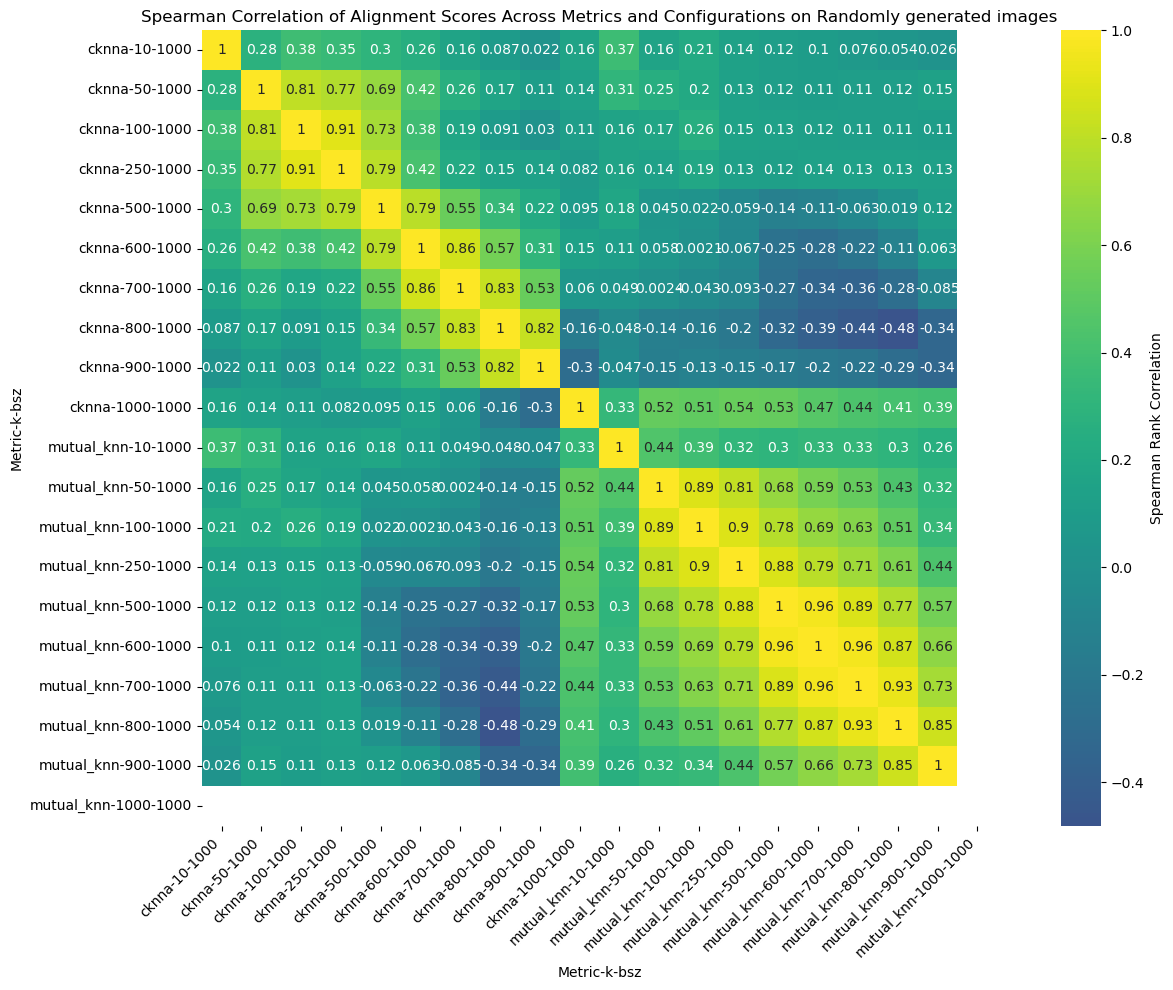

In [7]:
# Plot the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    square=True,
    center=0,
    cbar_kws={'label': 'Spearman Rank Correlation'}
)
plt.title('Spearman Correlation of Alignment Scores Across Metrics and Configurations on Randomly generated images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()